# YOLO_v5 XAI example

## 1. Import libraries

In [1]:
from typing import Final, List, Tuple
import os

import cv2
import numpy as np
import torch
import torchvision
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
from PIL import Image
import IPython

from autoxai.context_manager import AutoXaiExplainer, Explainers, ExplainerWithParams
from autoxai.explainer.base_explainer import CVExplainer
from example.yolov5_exmaple.yolo_utils import (  # scale_boxes,
    get_variables,
    letterbox,
    make_divisible,
    non_max_suppression,
    xywh2xyxy,
)

/home/kamil/Documents/python/AutoXAI/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Define target class to be explained.

In [2]:
TARGET: Final[int] = 0
""" The target class to be explained with XAI.

For yolo it takes all preditctions belonging to the given class.
It means that if 2 persons were detected, the XAI will be computed
for both of them. Instance specific XAI requires code modification.
"""

' The target class to be explained with XAI.\n\nFor yolo it takes all preditctions belonging to the given class.\nIt means that if 2 persons were detected, the XAI will be computed\nfor both of them. Instance specific XAI requires code modification.\n'

## 3. Craete model and open sample image.

Downaload YOLO model from torchhub and open sample image.
Check for CUDA device availability and move the model to CUDA if available.
Get number of classes and stride, used by the given YOLO model.

In [3]:
model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
image = Image.open(os.path.join(os.path.dirname(os.getcwd()),"images/zidane.jpg"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device=device)
params = dict(get_variables(model=model, include=("names", "stride")))

Using cache found in /home/kamil/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-17 Python-3.10.4 torch-1.12.1+cu116 CUDA:0 (NVIDIA GeForce RTX 3080 Ti, 12051MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## 4. Custom YOLO wrapper for XAI

By default YOLO model downloaded from torchhub is allready a wrapper on the YOLO model.
It has model.model(...), which perfomrs the regular YOLO prediction and custom model(...) method (forward(...) method), which do following steps:  
- image pre-processing (image, resizing, scaling, padding and normalization)
- model.model(...) call YOLO model on the pre-processed image
- non-max suppression algorithm, that removes duplicated bounding boxes and predictions with low confidence
- output bouniding-box scaling
- visualization optional
The output of the model(...) function is already postprocessed and contains only classes with high confidence and reduced number of bboxes.

YOLO models output.shape:

a) model(...)  
* if we feed the `troch.Tensor` it only runs model.model(...) and the output is of shape = <span style="color:orange">[B,15120,85].</span>, where 15120 are all object predictions, and 85 is:
    * bbox = [:4]
    * object confidence [5]
    * class confidence [6:] ,(80 classes)
* if we feed an numpy/PIL image it runs the whole pre- and post-processing pipeline described above.  The output object is of class `model.common.Detections` and condatins multiple fileds like `pred:List[torch.Tensor] = [[num_detections,6]]`, `xywh:List[torch.Tensor] = [[num_detections,6]]`,`xyxy:List[torch.Tensor] = [[num_detections,6]]` and other fields. `6` is an output of the non-max suppression algorithm used in YOLO. [:4] are bboxes, [5] is confidecne and [6] is class number.

b) model.model(...)
* we get same results as running model(...) with `torch.Tensor`. See above.


**Most XAI algorithms requires however output to be of shape:** <span style="color:orange">[B,number_of_classes]</span>

, where B is a  batch. It has also to be fully differentiable.

In order to get explanation for YOLO model we need to modify the YOLO model output shape `[B,1520,85] -> [B,80]`. The belowe `XaiYoloWrapper` does exactly this.

In [4]:
class XaiYoloWrapper(torch.nn.Module):
    """The Xai wrapper for the yolo model.

    Most explainers except the model output to consist
    only classes. However many models have custom outputs.
    In case of YOLO_v5 the output is [N,6] tensor, where:
        - N: is the number of predicted objects
        - [x,y,w,h,confidence,class]

    In order to make the output usable by regular
    xai expaliners, we need to convert the output
    to the following shape:
        - [cls1, cls2, ....., clsM], where M is
        the total number of classes.

    We loose the information about number of predictions
    and thier locations. In order to get those data
    we need to run the regular inference separately.
    """

    def __init__(self, model, conf: float = 0.25, iou: float = 0.45) -> None:
        """
        Args:
            mode: the yolo model to be used.
            conf: confidence threshold for predicted objects
            iou: iou threshold for preddicted bboxes for nms algorithm
        """
        super().__init__()
        self.model = model
        self.training = model.training

        params = dict(get_variables(model=model, include=("names")))
        self.number_of_classes: int = len(params["names"])
        self.conf: float = conf
        self.iou: float = iou

    def xai_non_max_suppression(
        self,
        prediction: torch.Tensor,
        conf_thres: float = 0.25,
        iou_thres: float = 0.45,
        agnostic: bool = False,
        max_det: int = 300,
    ) -> torch.Tensor:
        """Non-Maximum Suppression (NMS) on inference results to reject overlapping detections

        Args:
            prediction: the model prediction
            conf_thres: confidence threshold, for counting the detection as valid
            iou_thres: intersection over union threshold for non max suppresion algorithm
            agnostic:
            max_det: maximum number of detections

        Returns:
            batch of detections of shape (B,80), where 80 are classes confidence
        """

        # Checks
        assert (
            0 <= conf_thres <= 1
        ), f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
        assert (
            0 <= iou_thres <= 1
        ), f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
        if isinstance(
            prediction, (list, tuple)
        ):  # YOLOv5 model in validation model, output = (inference_out, loss_out)
            prediction = prediction[0]  # select only inference output

        device = prediction.device
        mps = "mps" in device.type  # Apple MPS
        if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
            prediction = prediction.cpu()
        bs = prediction.shape[0]  # batch size
        nc = prediction.shape[2] - 5  # number of classes
        # filter classes with high confidence
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        max_wh = 7680  # (pixels) maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()

        mi = 5 + nc  # mask start index
        m_out = torch.zeros((bs, self.number_of_classes), device=prediction.device)
        # pylint: disable = unnecessary-comprehension
        for xi, _ in enumerate([jj for jj in prediction]):
            x = prediction[xi]

            # Get predictions with high confidence
            x_high_conf = x.detach()[xc[xi]]
            # if there are no predictions with high confidence -> continue
            if not x_high_conf.shape[0]:
                # get class outputs
                x = x[:, 5:]
                # set all class outputs to zero (no gradient)
                # does outputs does not contribute to the final prediction
                x *= 0
                # sum same classes together to get the shape [number_of_objectes,num_of_classes] -> [num_of_classes]
                m_out[xi] = x.sum(dim=0)
                continue
            # Compute conf
            x_high_conf[:, 5:] *= x_high_conf[:, 4:5]  # conf = obj_conf * cls_conf
            box = xywh2xyxy(x_high_conf[:, :4])
            mask = x_high_conf[:, mi:]
            conf, j = x_high_conf[:, 5:mi].max(1, keepdim=True)
            x_high_conf = torch.cat((box, conf, j.float(), mask), 1)[
                conf.view(-1) > conf_thres
            ]
            n = x_high_conf.shape[0]  # number of boxes
            if not n:  # no boxes
                # get class outputs
                x = x[:, 5:]
                # set all class outputs to zero (no gradient)
                # does outputs does not contribute to the final prediction
                x *= 0
                # sum same classes together to get the shape [number_of_objectes,num_of_classes] -> [num_of_classes]
                m_out[xi] = x.sum(dim=0)
                continue
            # sort predicted objects from highest confidence to lowest and cut objects with
            # lowest confidence, if exceed max supported number of predictions
            x_indexs = x_high_conf[:, 4].argsort(descending=True)[:max_nms]
            x_high_conf = x_high_conf[x_indexs]
            c = x_high_conf[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = (
                x_high_conf[:, :4] + c,
                x_high_conf[:, 4],
            )  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            i = i[:max_det]  # limit detections
            # get indexes of x_high_conf tensor, with high confidence and non-overlaping bboxes
            x_indexs = x_indexs[i]


            # grab indexes x  tensor, with high confidence and non-overlaping bboxes
            pick_indices = xc[xi].nonzero()[x_indexs]

            # in place opeartions not supported for gradient computation
            # we need to clone the tensor and keep track of gradient
            class_confidence = x[:, 5:].clone()
            if class_confidence.requires_grad:
                class_confidence.retain_grad()
            object_confidence = x[:, 4:5].clone()
            if object_confidence.requires_grad:
                object_confidence.retain_grad()
            # compute the cls * obj confidence for final output
            x[:, 5:] = class_confidence * object_confidence
            # get only classes confidence
            x = x[:, 5:]
            # create a mask from those indexes. We want to keep shape of the original
            # x tensor and just zero outputs, that does not contribute to the final 
            # model output
            mask = torch.zeros_like(x)
            mask[pick_indices] = 1
            x = x * mask
            # sum same class instances together
            m_out[xi] = x.sum(dim=0)

        return m_out

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        x = self.xai_non_max_suppression(
            x,
            conf_thres=self.conf,
            iou_thres=self.iou,
            agnostic=False,
            max_det=1000,
        )  # NMS

        return x

## 5. Create a wrapped model

In [5]:
yolo_model = XaiYoloWrapper(model=model.model, conf=model.conf, iou=model.iou).to(
    device=device
)

## 6. Pre-process image

In [6]:
def pre_process(
    image: np.ndarray, sample_model_parameter: torch.Tensor, stride: int
) -> Tuple[torch.Tensor, List[int], List[int]]:
    """Transform the input image to the yolo network.

    Args:
        image: the input image to the network
        sample_model_parameter: the model parameter is used to read
        the model type (fp32/fp16) and target device
        stride: the yolo network stride

    Retuns:
        tensor image ready to be feed into the network
    """
    size: Tuple[int, int] = (640, 640)
    if image.shape[0] < 5:  # image in CHW
        image = image.transpose((1, 2, 0))  # reverse dataloader .transpose(2, 0, 1)
    image = (
        image[..., :3] if image.ndim == 3 else cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    )  # enforce 3ch input
    shape0 = image.shape[:2]  # HWC
    g = max(size) / max(shape0)  # gain
    shape1 = [int(y * g) for y in shape0]
    np_image = image if image.data.contiguous else np.ascontiguousarray(image)  # update
    shape1 = [make_divisible(x, stride) for x in np.array(shape1)]  # inf shape
    x = letterbox(np_image, shape1, auto=False)[0]  # pad
    x = np.ascontiguousarray(
        np.expand_dims(np.array(x), axis=0).transpose((0, 3, 1, 2))
    )  # stack and BHWC to BCHW
    x = (
        torch.from_numpy(x)
        .to(sample_model_parameter.device)
        .type_as(sample_model_parameter)
        / 255
    )  # uint8 to fp16/32

    return x, shape0, shape1

input_image, _, _ = pre_process(
    image=np.asarray(image),
    sample_model_parameter=next(model.parameters()),
    stride=params["stride"],
)
input_image = input_image.to(device)

## 7. Run XAI

In [7]:
with AutoXaiExplainer(
    model=yolo_model,
    explainers=[
        ExplainerWithParams(
            explainer_name=Explainers.CV_OCCLUSION_EXPLAINER,
            target=0,
        )
    ],
) as xai_model:
    _, attributions = xai_model(input_image)

attributions = attributions["CV_OCCLUSION_EXPLAINER"]

## 8. Run regular inference

Because the XAI was ran using wrapped model, the inference results from XAI are of shape `[B,80]`. The infomration about bboxes as well as about each instance is lost. We have only infomration about semantic classes detected in an image. Therefore in order to get instance level information with bboxes, we need to run the regular model once again.

In [8]:
# standard inference
y = model.model(input_image)
y = non_max_suppression(
    y,
    conf_thres=model.conf,
    iou_thres=model.iou,
    classes=None,
    agnostic=False,
    multi_label=False,
    max_det=1000,
)  # NMS

# uncomment in order to scale boxes to the original image size
# scale_boxes(shape1, y[0][:, :4], shape0)
y = y[0].detach().cpu()
bboxes = y[:, :4]
normalized_image: torch.Tensor = (
    (
        (input_image - torch.min(input_image))
        / (torch.max(input_image) - torch.min(input_image))
        * 255
    )
    .type(torch.uint8)
    .squeeze()
)
labels: List[str] = [params["names"][label.item()] for label in y[:, -1]]
pred_image = torchvision.utils.draw_bounding_boxes(
    image=normalized_image,
    boxes=bboxes,
    labels=labels,
)

## 9. Visualize results

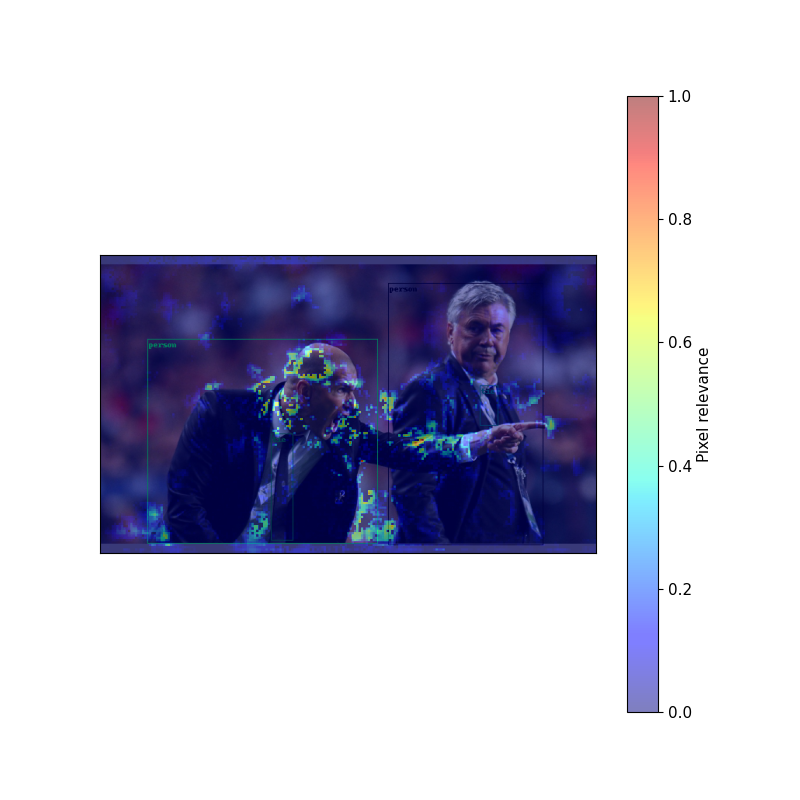

In [9]:
figure = CVExplainer.visualize(
    attributions=attributions.squeeze(), transformed_img=pred_image
)
canvas = FigureCanvas(figure)
canvas.draw()
buf = canvas.buffer_rgba()
image = np.asarray(buf)
cv2.putText(
    img=image,
    text=params["names"][TARGET],
    org=(image.shape[0] // 2, image.shape[1] // 8),
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=image.shape[0] / 500,
    color=(0, 0, 0),
)
IPython.display.display(Image.fromarray(image))